In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path, 0)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

for dict_key in dict_keys:
    for old_key, new_key in zip(OPS_bins, OPS_mid_point):
        OPS_APS[dict_key] = OPS_APS[dict_key].rename(columns = {old_key: new_key})

APS_dict_keys = ['20241016_APS', '20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[1:53].to_list()
APS_bin_mean = [(0.486968 + 0.523)/2]
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean.append(float(key))
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce') * 1.2
APS_cut_point = np.concatenate(([0.486968], (np.array(APS_bin_mean)[1:]+np.array(APS_bin_mean)[:-1])/2, [20.53]))

APS_mass_conc = {}
APS_mass_conc['20241016_APS'] = OPS_APS['20241016_APS']
for key in APS_dict_keys[1:3]:
    for i, bin in enumerate(APS_bins):
        bin_width = np.log10(APS_cut_point[i+1]) - np.log10(APS_cut_point[i])
        OPS_APS[key][bin] = pd.to_numeric(OPS_APS[key][bin]) * bin_width
    mass_conc = calc_mass_conc(OPS_APS[key], APS_bins, APS_bin_mean, 1.2)
    APS_mass_conc[key] = mass_conc

APS_number = pd.DataFrame({'Time': OPS_APS['20241016_APS']['Time']})
for i, key in enumerate(APS_bins):
        # Ensure df[key] is numeric
        OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce')
        
        APS_number[key] = OPS_APS['20241016_APS'][key] / ((1.2 / 10**6) * (np.pi / 6) * APS_bin_mean[i]**3 * 10**6) # in #/cm**3
OPS_APS['20241016_APS'] = APS_number

SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_bins = SMPS['20241016_SMPS'].keys()[4:117].to_list()
SMPS_bin_mean = []
for key in SMPS['20241016_SMPS'].keys()[4:117]:
    SMPS_bin_mean.append(float(key) / 1000)
SMPS_cut_point = np.concatenate(([0.017], (np.array(SMPS_bin_mean)[1:]+np.array(SMPS_bin_mean)[:-1])/2, [1.0]))

for key in SMPS_dict_keys[:3]:
    for i, bin in enumerate(SMPS_bins):
        bin_width = np.log10(SMPS_cut_point[i+1]) - np.log10(SMPS_cut_point[i])
        SMPS[key][bin] = pd.to_numeric(SMPS[key][bin]) * bin_width

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [43]:
OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

NS_OPS_cut = [0.010, 0.0132, 0.0179, 0.0234, 0.032, 0.0416, 0.057, 0.0739, 0.1015, 0.1314, 0.1805, 0.2337, 
              0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

time_wBG = [['2024-10-16 09:50:00', '2024-10-16 12:50:00'],
            ['2024-10-16 14:30:00', '2024-10-16 16:30:00'],
            ['2024-10-17 09:30:00', '2024-10-17 12:10:00'],
            ['2024-10-17 14:10:00', '2024-10-17 15:30:00']]

timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

In [5]:
print(OPS_APS['20241016_APS'].keys()[7:53])
print(SMPS['20241017_SMPS'].keys()[4:109])

Index(['0.777', '0.835', '0.898', '0.965', '1.037', '1.114', '1.197', '1.286',
       '1.382', '1.486', '1.596', '1.715', '1.843', '1.981', '2.129', '2.288',
       '2.458', '2.642', '2.839', '3.051', '3.278', '3.523', '3.786', '4.068',
       '4.371', '4.698', '5.048', '5.425', '5.829', '6.264', '6.732', '7.234',
       '7.774', '8.354', '8.977', '9.647', '10.37', '11.14', '11.97', '12.86',
       '13.82', '14.86', '15.96', '17.15', '18.43', '19.81'],
      dtype='object')
Index([' 17.5', ' 18.1', ' 18.8', ' 19.5', ' 20.2', ' 20.9', ' 21.7', ' 22.5',
       ' 23.3', ' 24.1',
       ...
       '532.8', '552.3', '572.5', '593.5', '615.3', '637.8', '661.2', '685.4',
       '710.5', '736.5'],
      dtype='object', name=0, length=105)


In [71]:
print(SMPS_cut_point[:86])
print(APS_cut_point[2:])

[0.017   0.0178  0.01845 0.01915 0.01985 0.02055 0.0213  0.0221  0.0229
 0.0237  0.02455 0.02545 0.0264  0.0274  0.0284  0.02945 0.03055 0.03165
 0.0328  0.034   0.03525 0.03655 0.03785 0.03925 0.0407  0.04215 0.0437
 0.0453  0.04695 0.0487  0.0505  0.05235 0.05425 0.05625 0.05835 0.06045
 0.06265 0.06495 0.0673  0.06975 0.07235 0.07505 0.07775 0.08055 0.08355
 0.08665 0.0898  0.09305 0.09645 0.1     0.10365 0.10745 0.1114  0.1155
 0.11975 0.1241  0.12865 0.1334  0.13825 0.1433  0.14855 0.154   0.15965
 0.1655  0.1716  0.1779  0.1844  0.19115 0.19815 0.2054  0.2129  0.2207
 0.2288  0.23715 0.24585 0.2549  0.26425 0.2739  0.2839  0.2943  0.3051
 0.3163  0.3279  0.3399  0.35235 0.36525]
[ 0.5625  0.6045  0.6495  0.698   0.75    0.806   0.8665  0.9315  1.001
  1.0755  1.1555  1.2415  1.334   1.434   1.541   1.6555  1.779   1.912
  2.055   2.2085  2.373   2.55    2.7405  2.945   3.1645  3.4005  3.6545
  3.927   4.2195  4.5345  4.873   5.2365  5.627   6.0465  6.498   6.983
  7.504   8.064  

In [9]:
SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_APS_number, SMPS_APS_mass, SMPS_APS_keys, SMPS_APS_bin_mean = merge_data(SMPS, SMPS_dict_keys, [4, 109], OPS_APS, APS_dict_keys, [7, 53], time_wBG, ['Time', 'Time'], True, False)

NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NS_OPS_number, NS_OPS_mass, NS_OPS_keys, NS_OPS_bin_mean = merge_data(SMPS, NanoScan_dict_keys, [3, 15], OPS_APS, dict_keys, [1, 17], time_wBG, ['Time', 'Time'], False, True)

SMPS_OPS_number, SMPS_OPS_mass, SMPS_OPS_keys, SMPS_OPS_bin_mean = merge_data(SMPS, SMPS_dict_keys, [4, 89], OPS_APS, dict_keys, [2, 17], time_wBG, ['Time', 'Time'], True, True)

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\calculations.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_small['Time'] = pd.to_datetime(df_small.index)
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\calculations.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_small['Time'] = pd.to_datetime(df_small.index)
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\calculations.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

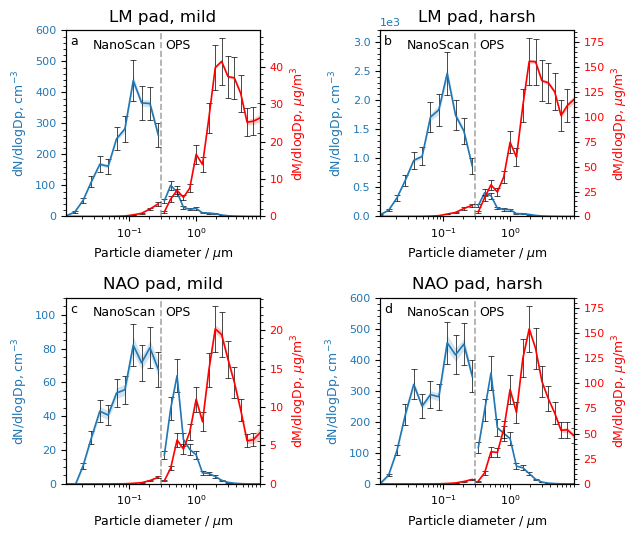

In [40]:
titles = ['LM pad, mild', 'LM pad, harsh', 'NAO pad, mild', 'NAO pad, harsh']
fig, axes = plt.subplots(2, 2, figsize = (6.5, 5.5))

for i, key in enumerate(dict_keys):
    if i == 0:
        ax = axes[0][0]
        y_max = 600
    if i == 1:
        ax = axes[0][1]
        y_max = 3200
    if i == 2:
        ax = axes[1][0]
        y_max = 110
    if i == 3:
        ax = axes[1][1]
        y_max = 600

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], NS_OPS_number[key], NS_OPS_mass[key], NS_OPS_keys, 'Time', NS_OPS_bin_mean, NS_OPS_cut, 0.15, 0.3, True)
    ax.vlines(0.3, 0, y_max, colors = 'darkgrey', linestyles = '--')
    ax.text(0.25, y_max - 0.1*y_max, 'NanoScan', ha = 'right', fontsize = 9)
    ax.text(0.35, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)

    ax.set_ylim(0, y_max)
    ax2.set_ylim(0, max(mass) + 0.2*max(mass))

    ax.set_title(titles[i])

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 9)

fig.tight_layout()
fig.savefig('Mean_concentrations/Nano_OPS_mean.png', dpi = 600)

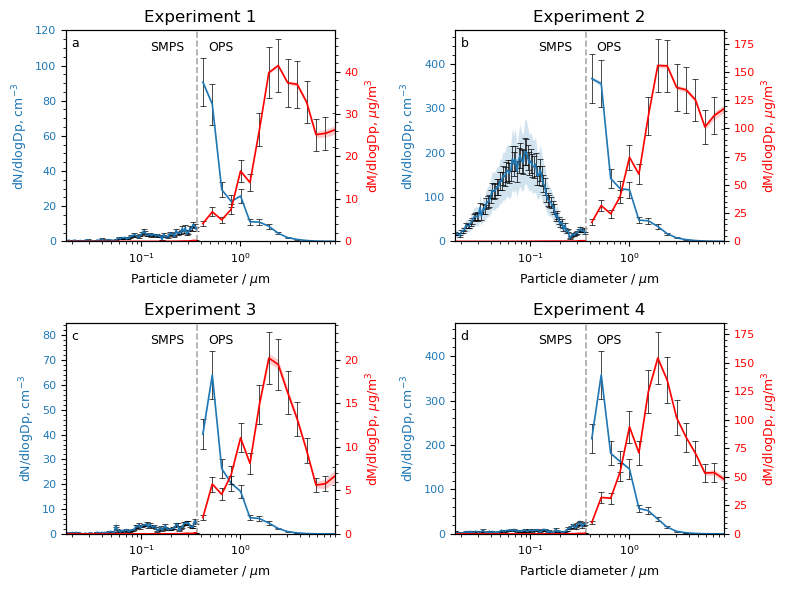

In [76]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(dict_keys):
    if i == 0:
        ax = axes[0][0]
        y_max = 120
    if i == 1:
        ax = axes[0][1]
        y_max = 475
    if i == 2:
        ax = axes[1][0]
        y_max = 85
    if i == 3:
        ax = axes[1][1]
        y_max = 475

    cut_point = SMPS_cut_point[:86].tolist() + OPS_cut_point[2:]

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS_OPS_number[key], SMPS_OPS_mass[key], SMPS_OPS_keys, 'Time', SMPS_OPS_bin_mean, cut_point, 0.15, 0.37, True)
    ax.vlines(0.37, 0, y_max, colors = 'darkgrey', linestyles = '--')
    ax.text(0.27, y_max - 0.1*y_max, 'SMPS', ha = 'right', fontsize = 9)
    ax.text(0.47, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)

    ax.set_ylim(0, y_max)
    ax2.set_ylim(0, max(mass) + 0.2*max(mass))
    
    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 9)

fig.tight_layout()
fig.savefig('Mean_concentrations/SMPS_OPS_mean.png', dpi = 600)

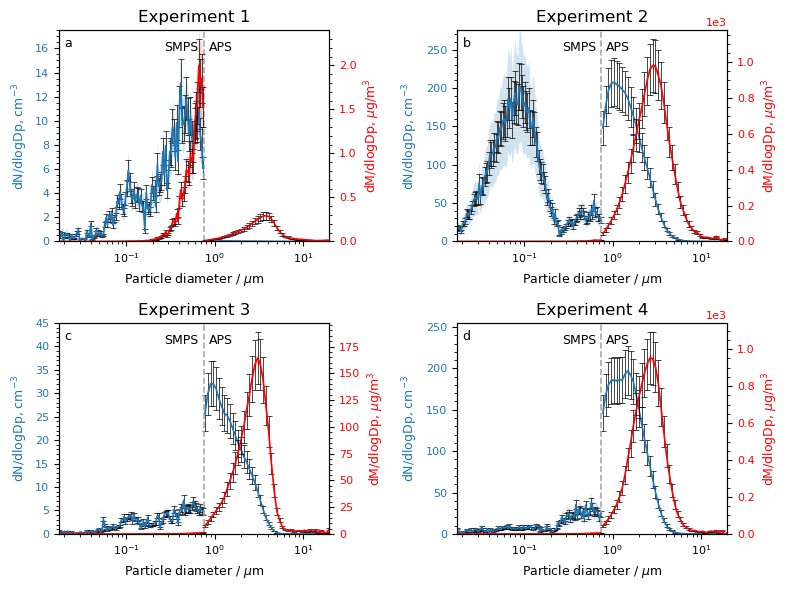

In [70]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(dict_keys):
    if i == 0:
        ax = axes[0][0]
        y_max = 17.5
    if i == 1:
        ax = axes[0][1]
        y_max = 275
    if i == 2:
        ax = axes[1][0]
        y_max = 45
    if i == 3:
        ax = axes[1][1]
        y_max = 255

    cut_point = np.concatenate((SMPS_cut_point[:106], APS_cut_point[7:])).tolist()

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS_APS_number[key], SMPS_APS_mass[key], SMPS_APS_keys, 'Time', SMPS_APS_bin_mean, cut_point, 0.15, 0.75, True)
    ax.vlines(0.75, 0, y_max, colors = 'darkgrey', linestyles = '--')
    ax.text(0.65, y_max - 0.1*y_max, 'SMPS', ha = 'right', fontsize = 9)
    ax.text(0.85, y_max - 0.1*y_max, 'APS', ha = 'left', fontsize = 9)

    ax.set_ylim(0, y_max)
    ax2.set_ylim(0, max(mass) + 0.2*max(mass))
    
    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 9)

fig.tight_layout()
fig.savefig('Mean_concentrations/SMPS_APS_mean.png', dpi = 600)

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")


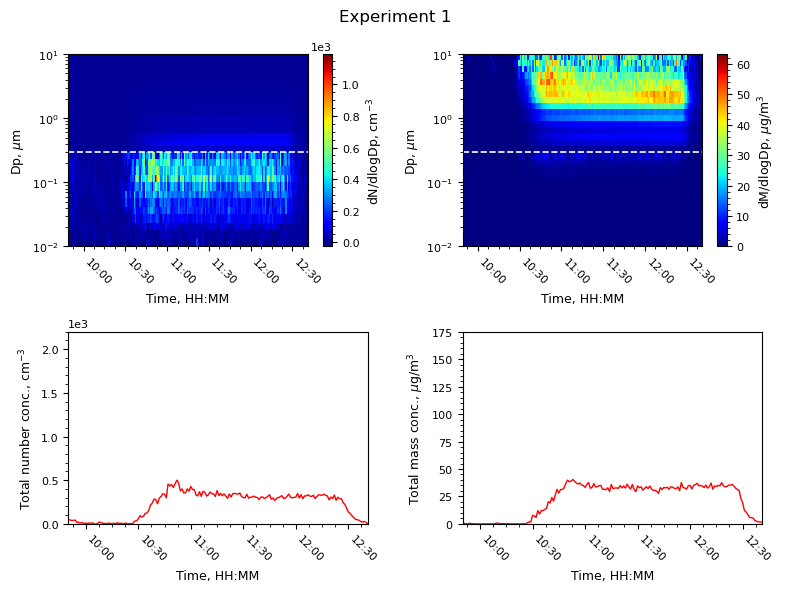

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")


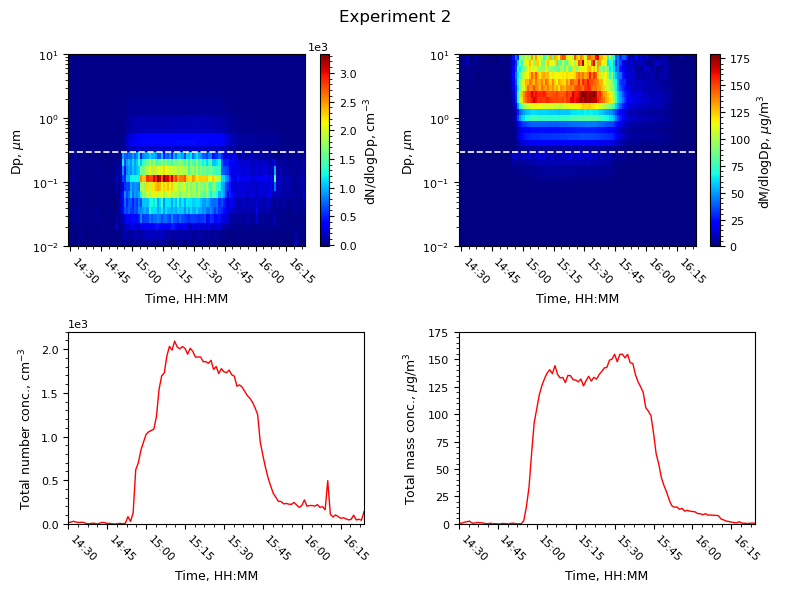

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")


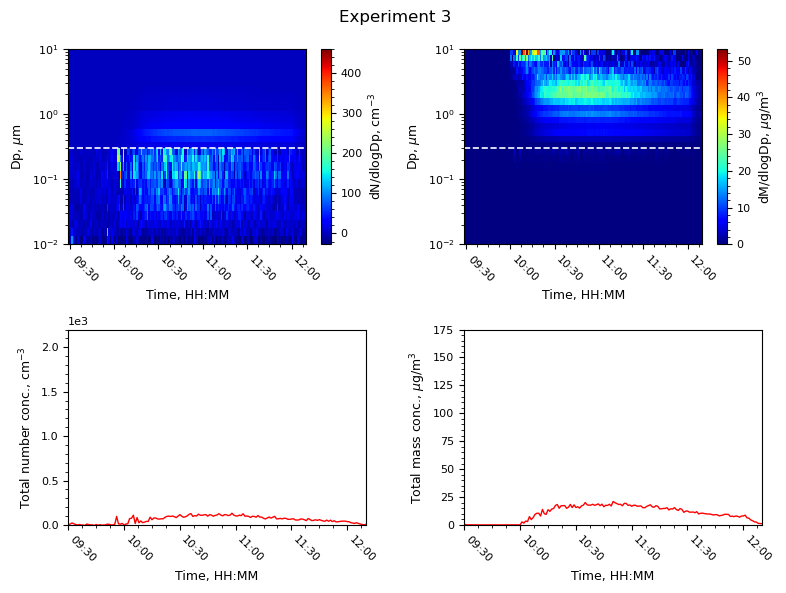

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:303: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")


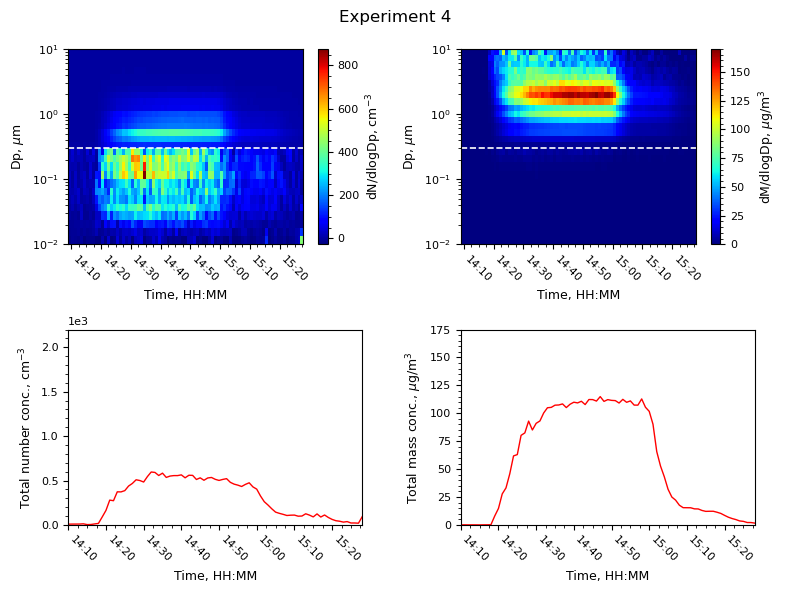

In [12]:
for i, key in enumerate(dict_keys):
    name = 'Timeseries/NS-OPS_timeseries_' + key + '.png'

    fig, ax = plt.subplots(2, 2, figsize = (8, 6))

    plot_timeseries(fig, ax, [NS_OPS_number[key], NS_OPS_mass[key]], NS_OPS_keys, NS_OPS_cut, 'number and mass', time_wBG[i], False, [0.3, 'NanoScan', 'OPS'])

    ax[1][0].set_ylim(0, 2200)
    ax[1][1].set_ylim(0, 175)

    title = 'Experiment ' + str(i + 1)
    fig.suptitle(title)

    fig.tight_layout()
    fig.savefig(name, dpi = 600)
    plt.show()